In [2]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from Lacoste_utils import add_monthly_UAE_holiday_count,get_lag_features, create_peak_calendar,merge_peak_calendar_info,create_monthly_seasonal_features,get_rate_of_sale_monthly,get_monthly_seasonality_index,get_moving_stats_features, add_monthly_derivative_features, add_monthly_flags,create_weather_season_features, add_ramadan_features, add_eid_features,add_shopping_events, add_luxury_seasons, create_holiday_features  
import category_encoders as ce
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
from typing import Optional, List, Tuple,  Callable, Dict, Union
import re
import os
import joblib
import holidays
import pickle
import fsspec

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
brand = 'LACOSTE'
country = 'UAE'
data_start_date = '2023-01-01'
train_end_date="2025-04-30"
cut_off_date='2025-07-01'
cutoff_month="2025-07"
data_end_date = '2026-12-31'

target = 'units' #_quantity'
fc_horizon=18
# Starting date
dt = datetime.strptime(train_end_date, "%Y-%m-%d")
date=dt + relativedelta(day=1)+relativedelta(months=fc_horizon)
horizon_end_date=date.strftime("%Y-%m-%d")
fc_start_date=dt + relativedelta(day=1)+relativedelta(months=1)
fc_start_date=fc_start_date.strftime("%Y-%m-%d")

base_vars = {"key": "key",
             "target": "target",
             "date": "date"}


gcs_path = "gs://trd-sf-ntb"
experiment_name = "model_pipeline"  # or something like f"exp_{datetime.now():%Y%m%d_%H%M%S}"
file_input1 = "monthly_temporal_features.parquet"
file_input2 = "monthly_lever_features.parquet"
file_input3 = "monthly_features_mmm_faces.parquet"
file_input4= "store_features.parquet"
file_input5="feature_store.parquet"
output = 'monthly_lacoste_forecast.parquet'

local_model_dir="saved_models/tuned/april"
os.makedirs(local_model_dir, exist_ok=True)

local_res_dir="saved_results/tuned/april"
os.makedirs(local_res_dir, exist_ok=True)


# full_path = f"{gcs_path}/{brand}_only/{target}/{experiment_name}/{fc_start_date}/{file_input5}"

In [5]:
fc_start_date, horizon_end_date

('2025-05-01', '2026-10-01')

In [6]:
def eda_features(df_input: pd.DataFrame, feature_name: str):
    '''
    feature_name can only be following : temporal, promotion, marketing, store
    '''
    print(f"------EDA on {feature_name} features------------------")
    try:
        print(f"min & max dates {df_input.date.min().date()},{df_input.date.max().date()}",end="\n\n")
    except:
        pass
    print(f"shape of dataset : {df_input.shape}",end="\n\n")
    print(f"{feature_name} features: {df_input.columns.values}",end="\n\n")
    print(f"missing values :\n{df_input.isnull().sum()}")

### read feature store

In [7]:
full_path = f"{gcs_path}/{target}/{brand}/{experiment_name}/{cutoff_month}/{train_end_date}/{file_input5}"
full_path

'gs://trd-sf-ntb/units/LACOSTE/model_pipeline/2025-07/2025-04-30/feature_store.parquet'

In [115]:
df_ml=pd.read_parquet(full_path)
eda_features(df_ml,"complete")

------EDA on complete features------------------
min & max dates 2023-07-01,2026-10-01

shape of dataset : (457, 49)

complete features: ['key' 'date' 'target' 'holiday_count' 'fourier_year_sin'
 'fourier_year_cos' 'Lag12_y' 'MA6_y' 'STD6_y' 'Seasonality_Index'
 'UAE_shopping_peak_ratio' 'deriv_1_pct' 'deriv_2_pct' 'deriv_3_pct'
 'deriv_6_pct' 'deriv_1_flag' 'ramadan_period' 'public_holidays'
 'is_high_sales_intent_flag' 'shopping_event_code' 'fashion_week_season'
 'count_of_days' 'uae_seasons' 'total_cost_usd_facebook'
 'total_cost_usd_google' 'total_cost_usd_instagram'
 'total_cost_usd_tiktok' 'city' 'is_ecom_fullfillment_loc'
 'selling_square_ft' 'selling_square_ft_cat' 'distinct_discount_levels'
 'avg_discount' 'max_discount' 'min_discount' 'avg_promo_duration'
 'promo_days_in_month' 'percentage_products_on_promo' 'channel_encode'
 'store_format_encode' 'key_encode' 'festive_peak_flag_encode'
 'deriv_2_trend_flag_encode' 'quarter_sin' 'quarter_cos'
 'channel_Farfetch' 'channel_Reta

In [116]:
df_ml.drop("tourists",axis=1,inplace=True)

### Train-test split

In [117]:
df_train=df_ml[pd.to_datetime(df_ml.date)<=train_end_date]
df_test=df_ml[(pd.to_datetime(df_ml.date)>train_end_date) &((pd.to_datetime(df_ml.date)<=horizon_end_date))]
x_train=df_train.drop(["target","key","date"],axis=1)
y_train=df_train["target"]
x_test=df_test.drop(["target","key","date"],axis=1)
y_test=df_test["target"]

In [118]:
x_train.isnull().sum()

holiday_count                   0
fourier_year_sin                0
fourier_year_cos                0
Lag12_y                         0
MA6_y                           0
STD6_y                          0
Seasonality_Index               0
UAE_shopping_peak_ratio         0
deriv_1_pct                     0
deriv_2_pct                     0
deriv_3_pct                     0
deriv_6_pct                     0
deriv_1_flag                    0
ramadan_period                  0
public_holidays                 0
is_high_sales_intent_flag       0
shopping_event_code             0
fashion_week_season             0
count_of_days                   0
uae_seasons                     0
total_cost_usd_facebook         0
total_cost_usd_google           0
total_cost_usd_instagram        0
total_cost_usd_tiktok           0
city                            0
is_ecom_fullfillment_loc        0
selling_square_ft               0
selling_square_ft_cat           0
distinct_discount_levels        0
avg_discount  

In [119]:
# df_test.reset_index(inplace=True)
df_test["Pred_Flag"]=1
df_train["Pred_Flag"]=0
# test_end_date=df_test.date.max()

In [120]:
df_input=pd.concat([df_train,df_test],axis=0)
main_df =df_train.copy()
future_rows_to_predict =df_test.copy()

In [121]:
df_input.isnull().sum()

key                               0
date                              0
target                          180
holiday_count                     0
fourier_year_sin                  0
fourier_year_cos                  0
Lag12_y                         180
MA6_y                           180
STD6_y                          180
Seasonality_Index               180
UAE_shopping_peak_ratio           0
deriv_1_pct                     180
deriv_2_pct                     180
deriv_3_pct                     180
deriv_6_pct                     180
deriv_1_flag                    180
ramadan_period                  180
public_holidays                 180
is_high_sales_intent_flag       180
shopping_event_code             180
fashion_week_season             180
count_of_days                   180
uae_seasons                     180
total_cost_usd_facebook           0
total_cost_usd_google             0
total_cost_usd_instagram          0
total_cost_usd_tiktok             0
city                        

In [122]:
future_rows_to_predict.columns[future_rows_to_predict.isnull().sum()>0]

Index(['target', 'Lag12_y', 'MA6_y', 'STD6_y', 'Seasonality_Index',
       'deriv_1_pct', 'deriv_2_pct', 'deriv_3_pct', 'deriv_6_pct',
       'deriv_1_flag', 'ramadan_period', 'public_holidays',
       'is_high_sales_intent_flag', 'shopping_event_code',
       'fashion_week_season', 'count_of_days', 'uae_seasons',
       'deriv_2_trend_flag_encode'],
      dtype='object')

In [123]:
x_train.columns

Index(['holiday_count', 'fourier_year_sin', 'fourier_year_cos', 'Lag12_y',
       'MA6_y', 'STD6_y', 'Seasonality_Index', 'UAE_shopping_peak_ratio',
       'deriv_1_pct', 'deriv_2_pct', 'deriv_3_pct', 'deriv_6_pct',
       'deriv_1_flag', 'ramadan_period', 'public_holidays',
       'is_high_sales_intent_flag', 'shopping_event_code',
       'fashion_week_season', 'count_of_days', 'uae_seasons',
       'total_cost_usd_facebook', 'total_cost_usd_google',
       'total_cost_usd_instagram', 'total_cost_usd_tiktok', 'city',
       'is_ecom_fullfillment_loc', 'selling_square_ft',
       'selling_square_ft_cat', 'distinct_discount_levels', 'avg_discount',
       'max_discount', 'min_discount', 'avg_promo_duration',
       'promo_days_in_month', 'percentage_products_on_promo', 'channel_encode',
       'store_format_encode', 'key_encode', 'festive_peak_flag_encode',
       'deriv_2_trend_flag_encode', 'quarter_sin', 'quarter_cos',
       'channel_Farfetch', 'channel_Retail', 'pre_post_rm_flg'],


### Models - function

In [124]:
def random_forest(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_test: pd.DataFrame,
    model_parameters: dict,
    tuning: bool=True ,
    key:str = 'Test',
    inference_flag:bool = False,
    verbose: bool = True
):
    """
    random_forest model - multivariate model with two options .True for hyperparameter tuning and False for fixed values for parameters.
    Input is a dataframe with target column (independent variable) and features created from create_features() function.
    Args
        :param x_train: Training dataset with the regressors
        :param y_train: Target data
        :param x_test: Testing dataset with the regressors
        :param model_parameters: dictionary of parameters
        :param tuning: hyperparameter setting
    Returns:
        list containing the forecast values
    """
    if tuning==True:
        params = model_parameters["True"]
        reg = parameter_tuning(
            x_train = x_train,
            y_train = y_train,
            regressor = RandomForestRegressor(),
            params = params,
            n_iter = 10
        )
        model = reg.best_estimator_
        model.fit(x_train,y_train)
        if inference_flag == True:
            return model
        # pred = model.predict(x_test)
        return model
    else:
        params = model_parameters["False"]
        n_estimators = params["n_estimators"]
        max_depth = params["max_depth"]
        model = RandomForestRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
        )
        model.fit(x_train,y_train)
        if inference_flag == True:
            return model
        # pred = model.predict(x_test)
        return model

def xgboost(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_test: pd.DataFrame,
    model_parameters: dict,
    tuning: bool = True,
    key:str = 'Test',
    inference_flag:bool = False,
    verbose: bool = True
):
    """
    xg_boost model - multivariate model with two options .True for hyperparameter tuning and False for fixed values for parameters.
    """
    # Replace infinite values with NaN
    x_train = x_train.replace([np.inf, -np.inf], np.nan)
    x_test = x_test.replace([np.inf, -np.inf], np.nan)
    
    if tuning == True:
        params = model_parameters["True"].copy()
        params['missing'] = np.nan  # Ensure missing is set to handle NaN
        
        reg = parameter_tuning(
            x_train = x_train,
            y_train = y_train,
            regressor = XGBRegressor(enable_categorical=True, missing=np.nan),
            params = params,
            n_iter = 10
        )
        model = reg.best_estimator_
        model.fit(x_train, y_train)
        if inference_flag == True:
            return model
        # pred = model.predict(x_test)
    else:
        params = model_parameters["False"].copy()
        params['missing'] = np.nan  # Ensure missing is set to handle NaN
        
        model = XGBRegressor(
            enable_categorical=True,
            missing=np.nan,
            n_estimators = params["n_estimators"],
            learning_rate = params["learning_rate"],
            max_depth = params["max_depth"],
            n_jobs = params["n_jobs"],
            alpha = params["alpha"],
            tree_method = params.get("tree_method", 'hist')
        )
        model.fit(x_train, y_train)
        if inference_flag == True:
            return model
        # pred = model.predict(x_test)

    return model

def lgbm(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    x_test: pd.DataFrame,
    model_parameters: dict,
    tuning: bool = True,
    key:str = 'Test',
    inference_flag:bool = False,
    verbose: bool = True
):
    """
    LightGBM forecast model
    """
    # Replace infinite values with NaN
    x_train = x_train.replace([np.inf, -np.inf], np.nan)
    x_test = x_test.replace([np.inf, -np.inf], np.nan)
    
    if tuning == True:
        params = model_parameters["True"].copy()
        params.pop('verbose', None)
        reg = parameter_tuning(
            x_train = x_train,
            y_train = y_train,
            regressor = LGBMRegressor(),
            params = params,
            n_iter = 10
        )
        model = reg.best_estimator_
        model.fit(x_train,y_train)
        if inference_flag == True:
            return model
        # pred = model.predict(x_test)
    else:
        params = model_parameters["False"]
        model = LGBMRegressor(
            objective = params["objective"],
            boosting_type = params["boosting_type"],
            num_leaves= params["num_leaves"],
            learning_rate = params["learning_rate"],
            force_col_wise = params["force_col_wise"],
            verbose= params["verbose"],
            seed= params["seed"]
        )
        model.fit(x_train,y_train)
        if inference_flag == True:
            return model
        # pred = model.predict(x_test)
    return model

In [125]:
multivariate_model_list = ['xgboost', 'lgbm', 'random_forest']

model_test = {
    'xgboost': xgboost,
    'lgbm': lgbm,
    'random_forest': random_forest
}

model_parameters_dict = {
    "lgbm": {
        "True": {
            'objective': ['regression'],
            'metric': ['mse'],
            'boosting_type': ['gbdt'],
            'num_leaves': [25,30,35,40],
            'learning_rate': [0.01,0.02,0.05,0.07],
            'feature_fraction': [0.5,0.7,0.9],
            'bagging_fraction': [0.7,0.75,0.8],
            'bagging_freq': [2,5,7],
            'verbose': 0,
            'seed': [42]
        },
        "False": {
            'objective': 'regression',
            'metric': 'mse',
            'boosting_type': 'gbdt',
            'num_leaves': 4,
            'learning_rate': 0.05,
            'force_col_wise': True,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 0,
            'seed': 42
        }
    },
    "xgboost": {
        "True": {
            "max_depth": list(range(3, 10 + 1)),
            "learning_rate": [0.3, 0.2, 0.1, 0.05],
            "tree_method": ['hist'],
            "missing": [np.nan],  # Explicitly handle missing values
            "n_estimators": list(range(100, 300 + 1, 20)),
            "gamma": [0, 0.1, 0.01, 0.001],
            "subsample": [0.9, 0.8, 0.7],
            "colsample_bytree": [0.9, 0.8, 0.7],
            "colsample_bylevel": [0.9, 0.8, 0.7],
            "scale_pos_weight": [0.9, 0.8, 0.7],
            "importance_type": ['gain', 'weight', 'cover', 'total_gain', 'total_cover']
        },
        "False": {
            "n_estimators": 500,
            "learning_rate": 0.05,
            "max_depth": 6,
            "n_jobs": 1,
            "alpha": 0.1,
            "tree_method": 'hist',
            "missing": np.nan  # Explicitly handle missing values
        }
    },
    "random_forest": {
        "True": {
            "n_estimators": list(range(100, 300 + 1, 10)),
            "max_depth": list(range(3, 15 + 1)),
            "min_samples_split": [2, 3, 4, 5, 6],
            "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7],
            "max_features": [None, 'sqrt', 'log2', 0.9, 0.85, 0.75],
            "bootstrap": [True, False]
        },
        "False": {
            "n_estimators": 50,
            "max_depth": 200,
        }
    }
}

In [126]:
def parameter_tuning(x_train, y_train, regressor, params, n_iter=10):
    """
    Perform RandomizedSearchCV for hyperparameter tuning with proper parameter handling
    """
    # Replace infinite values if not already done
    x_train = x_train.replace([np.inf, -np.inf], np.nan)
    
    # Make a copy of params to avoid modifying the original
    search_params = params.copy()
    
    # For XGBoost, ensure missing parameter is properly formatted
    if isinstance(regressor, XGBRegressor):
        if 'missing' in search_params:
            # If missing is specified as a single value, wrap it in a list
            if not isinstance(search_params['missing'], (list, np.ndarray)):
                search_params['missing'] = [search_params['missing']]
    
    search = RandomizedSearchCV(
        estimator=regressor,
        param_distributions=search_params,
        scoring='neg_root_mean_squared_error',
        n_iter=n_iter,
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    search.fit(x_train, y_train)
    return search

### Recursive features

In [127]:
def feature_combine_pd(dataframe: pd.DataFrame,
                       dfu_columns: list[str],
                       feature_list: dict[str, any],
                       key: str,
                       ds: str,
                       target: str) -> pd.DataFrame:

    temp_df = dataframe.copy()

    temp_df = get_lag_features(temp_df, [12], key=key, date_col=ds, target=target)
    temp_df = get_moving_stats_features(temp_df, months_back=[6])
    temp_df = get_monthly_seasonality_index(temp_df, 'date', 'target')
    
    # temp_df=create_monthly_seasonal_features(temp_df,'date', 'target','key')
    
    # Add year column if not already there
    if 'year' not in temp_df.columns:
        temp_df['year'] = pd.to_datetime(temp_df[ds]).dt.year

    # Generate & merge rate_of_sale
    rate_of_sale_df = get_rate_of_sale_monthly(temp_df, [key])
    temp_df = temp_df.merge(rate_of_sale_df, on=[key, 'year'], how='left')
    
    monthly_df = add_monthly_derivative_features(temp_df)
    monthly_df = add_monthly_flags(monthly_df)
    
    print("1", monthly_df.columns)

    monthly_df = monthly_df.rename(columns={'year_month': 'date'})
    # print("2", monthly_df.columns)
    
    # List of columns to replace from monthly_df
    columns_to_replace = ['deriv_1_pct', 'deriv_2_pct', 'deriv_3_pct', 'deriv_6_pct', 'deriv_1_flag']  # customize this

    # Merge with monthly_df — include deriv_2_trend_flag without dropping it
    cols_to_merge = ['key', 'date'] + columns_to_replace + ['deriv_2_trend_flag']
    # Drop those from temp_df first
    temp_df.drop(columns=columns_to_replace, inplace=True)
    print(temp_df.columns)
 

    # Now merge without suffixes (since there’s no conflict)
    temp_df = temp_df.merge(monthly_df[cols_to_merge], on=['key', 'date'], how='left')
    
    # temp_df = temp_df.merge(monthly_df, on=['key', 'date'], how='left')
    
    # print("3", temp_df.columns)

    # Load the mapping DataFrame from the pickle file
    mapping_df = pd.read_pickle('deriv_2_trend_flag_mapping.pkl')

    # Create a mapping dictionary from the DataFrame
    mapping_dict = dict(zip(mapping_df['deriv_2_trend_flag'], mapping_df['deriv_2_trend_flag_encode']))
    
    # print("Mapping file loaded with keys:", list(mapping_dict.keys()))

    # Apply the mapping to temp_df to create the encoded column
    temp_df['deriv_2_trend_flag_encode'] = temp_df['deriv_2_trend_flag'].map(mapping_dict)
    # encode={-1:1583.333368,1:1851.039706,0:1283.496105}
    # temp_df["deriv_2_trend_flag"]=temp_df["deriv_2_trend_flag"].apply(lambda x: encode[x])
    
    temp_df.drop(columns=['deriv_2_trend_flag'], inplace=True)
    
    print(temp_df.columns)
    # print('deriv_2_trend_flag_encode' in temp_df.columns)
    # print('deriv_2_trend_flag' in temp_df.columns)
    return temp_df

In [128]:
def forecast_loop_store(key,df_in,model_pred, expected_features,
                  feature_list,model_name):
    future_rows_to_predict=df_in[df_in["Pred_Flag"]==1].copy()
    future_rows_to_predict.sort_values("date",inplace=True)
    main_df=df_in[df_in["Pred_Flag"]==0].copy()
    main_df.sort_values("date",inplace=True)
    
    for i in range(len(future_rows_to_predict)):
        data_sv=[]
        row_to_forecast = future_rows_to_predict.iloc[[i],:].copy()
        date=row_to_forecast["date"].values[0]
        # print(date)
        pred_flag=row_to_forecast["Pred_Flag"].values[0]
        temp_df = pd.concat([main_df, row_to_forecast], ignore_index=True)
        # print(temp_df.columns)
        temp_df.drop(columns=feature_list, errors='ignore', inplace=True)

        # Generate features
        feature_df = feature_combine_pd(temp_df, ['key'], feature_list, 'key', 'date', 'target')
        
        model_input = feature_df.reindex(columns=expected_features, fill_value=0)

        row_pred = model_input.iloc[[-1]]  # Last row is the forecast row
        column_name=expected_features.copy()
        column_name.extend(["target",'key', 'date','Pred_Flag'])
        # Predict
        pred = model_pred.predict(row_pred)
        record=list(np.concatenate([row_pred.values.flatten(),pred.flatten()]).reshape(len(row_pred.values[0])+1))
        record.append(key)
        record.append(date)
        record.append(pred_flag)
        data_sv.append(record)
       
        # Update prediction in the future dataframe
        future_rows_to_predict.iloc[i, future_rows_to_predict.columns.get_loc('target')] = pred[0]
        # Append predicted row to df for next iteration
        row_to_forecast['target'] = pred[0]
        df_res=pd.DataFrame(data_sv,columns=column_name)
        main_df = pd.concat([main_df[column_name], df_res], ignore_index=True)
        
    # df_res=pd.DataFrame(data_sv,columns=column_name)
    # df_res2=pd.concat([main_df[column_name],df_res],ignore_index=True)

    local_key_forecast_path = os.path.join(local_res_dir, f"{key}_{model_name}_forecast_.csv")
    
    print(f"{local_key_forecast_path}")
    main_df.to_csv(local_key_forecast_path)
    
     # Prepare forecast_df with predictions
    forecast_df = future_rows_to_predict[['key', 'date', 'target']].copy()
    forecast_df.rename(columns={'target': 'forecast'}, inplace=True)
    forecast_df['run_status'] = f"{df_in['key'].iloc[0]} success"
    return forecast_df


### Inference - Champion challenger model

In [129]:
def multivariate_model_sprint(df_input,x_train,y_train,x_test,y_test):
    final = pd.DataFrame()
    for model_name in multivariate_model_list:
        print(x_test.columns)
     
        model_func = model_test[model_name]
        print(model_func)
        # Initialize a DataFrame to hold the results for the current model
        master = pd.DataFrame(columns=[base_vars['date'], base_vars['key'], 'forecast'])

        # Call the current model function to generate forecasts
        model= model_func(
            x_train.drop([base_vars['key'], base_vars['date']], axis=1),
            y_train.drop([base_vars['key']], axis=1),
            x_test.drop([base_vars['key'], base_vars['date']], axis=1),
            model_parameters=model_parameters_dict[model_name],  # Model-specific parameters
            tuning=True  # Tuning flag for hyperparameters
        )
        expected_features = X_train_1.drop([base_vars['key'], base_vars['date']], axis=1).columns.tolist()
        model_package = (model, expected_features)
        # Record the status as success
        
    
        
        local_model_path = os.path.join(local_model_dir, f"{model_name}_model.pkl")
        with open(local_model_path, 'wb') as f:
            pickle.dump(model_package, f)


        all_keys=x_test["key"].unique().tolist()

      
        local_model_path = os.path.join(local_model_dir, f"{model_name}_model.pkl")
        with open(local_model_path, 'rb') as f:
            model1 = pickle.load(f)
            print(model1)
            model=model1[0]
            expected_features=model1[1]
        # print(model)
        # generating forecast for stores
        dff=pd.DataFrame({})
        for k in all_keys:
            df_key=df_input[df_input["key"]==k].copy()
            # print(df_key.head())
            df_forecast=forecast_loop_store(k,df_key,model ,expected_features,feature_list,model_name)
            dff=pd.concat([dff,df_forecast],axis=0,ignore_index=True)


        merged_df=pd.merge(df_test[[base_vars['date'], base_vars['key'],base_vars['target']]],dff,how="left",on=[base_vars['date'], base_vars['key']])
        # apr_may_jun_df=merged_df[merged_df["date"]<"2025-07-01"].reset_index(drop=True)

        ovrll_forecast_path = os.path.join(local_res_dir, f"forecast_jun2026_{model_name}.csv")
        dff.to_csv(ovrll_forecast_path,index=False)
        dff['run_status_' + model_name] = 'success'

        dff=dff[master.columns]
        # Concatenate the current model results to the master DataFrame
        master = pd.concat([master, dff], axis=0)

        # Drop rows with NaN in the key column to clean up the results
        master.dropna(subset=[base_vars['key']], inplace=True)

        # Rename the forecast column to include the model name
        master.rename(columns={'forecast': f'forecast_{model_name}'}, inplace=True)

        # Ensure the date column is in datetime format
        master[base_vars['date']] = pd.to_datetime(master[base_vars['date']])
        # master.to_csv('inter_out.csv',index=False)

        # Merge the results into the final DataFrame
        if final.empty:
            final = master.copy()  # If final is empty, initialize it with master
        else:
            if base_vars['target'] in final.columns.tolist():
                final.drop('target',axis=1,inplace=True)
            final = pd.merge(final, master, on=[base_vars['key'], base_vars['date']], how='inner')  # Merge
        
        # Merge the predicted values with the actual data
        final = pd.merge(final, df_input[df_input["Pred_Flag"]==1][[base_vars['date'], base_vars['key'],base_vars['target']]], on=[base_vars['key'], base_vars['date']], how='left')

        # Replace any NaN values in the final DataFrame with infinity
        final.fillna(np.inf, inplace=True)
        
    return final

In [130]:
feature_list=['Lag12_y', 'MA6_y', 'STD6_y','Seasonality_Index']

In [131]:
# for model_name in ["xgboost","lightgbm","random_forest"]:
df_train=df_ml[pd.to_datetime(df_ml.date)<=train_end_date]
df_test=df_ml[(pd.to_datetime(df_ml.date)>train_end_date) &((pd.to_datetime(df_ml.date)<=data_end_date))]

X_train_1 = df_train.drop([base_vars['target']],axis=1) # Training features
X_test_1 =df_test.drop([ base_vars['target']],axis=1)   # Test features
Y_train_1 =df_train[[base_vars['target'],base_vars["key"]]] # Training target
Y_test = df_test[[base_vars['target'],base_vars["key"]]]  # Test target

In [132]:
completed_fc=multivariate_model_sprint(df_input,X_train_1,Y_train_1,X_test_1,Y_test)

Index(['key', 'date', 'holiday_count', 'fourier_year_sin', 'fourier_year_cos',
       'Lag12_y', 'MA6_y', 'STD6_y', 'Seasonality_Index',
       'UAE_shopping_peak_ratio', 'deriv_1_pct', 'deriv_2_pct', 'deriv_3_pct',
       'deriv_6_pct', 'deriv_1_flag', 'ramadan_period', 'public_holidays',
       'is_high_sales_intent_flag', 'shopping_event_code',
       'fashion_week_season', 'count_of_days', 'uae_seasons',
       'total_cost_usd_facebook', 'total_cost_usd_google',
       'total_cost_usd_instagram', 'total_cost_usd_tiktok', 'city',
       'is_ecom_fullfillment_loc', 'selling_square_ft',
       'selling_square_ft_cat', 'distinct_discount_levels', 'avg_discount',
       'max_discount', 'min_discount', 'avg_promo_duration',
       'promo_days_in_month', 'percentage_products_on_promo', 'channel_encode',
       'store_format_encode', 'key_encode', 'festive_peak_flag_encode',
       'deriv_2_trend_flag_encode', 'quarter_sin', 'quarter_cos',
       'channel_Farfetch', 'channel_Retail', 'pre_

In [175]:
ovrll_forecast_path = os.path.join(local_res_dir, f"lacoste_forecast_jun2026_ovrall.csv")
completed_fc.to_csv(ovrll_forecast_path,index=False)

In [176]:
ovrll_forecast_path

'saved_results/tuned/april/lacoste_forecast_jun2026_ovrall.csv'

In [177]:
completed_fc[completed_fc.duplicated()]

,date,key,forecast_xgboost,forecast_lgbm,forecast_random_forest,target


In [178]:
ovrll_forecast_path = os.path.join(local_res_dir, f"lacoste_forecast_jun2026_ovrall.csv")

In [179]:
ovrll_forecast_path

'saved_results/tuned/april/lacoste_forecast_jun2026_ovrall.csv'

In [180]:
forecast_df=pd.read_csv(ovrll_forecast_path)

In [181]:
forecast_df.shape

(216, 6)

In [182]:
forecast_df=forecast_df[~forecast_df["key"].isin([52004])]

In [183]:
forecast_df.shape

(216, 6)

In [184]:
f"{gcs_path}/{target}/{brand}/{experiment_name}/{output}"

'gs://trd-sf-ntb/units/LACOSTE/model_pipeline/monthly_lacoste_forecast.parquet'

In [185]:
forecast_df[forecast_df.duplicated()]

,date,key,forecast_xgboost,forecast_lgbm,forecast_random_forest,target


In [186]:
forecast_df.to_parquet(f"{gcs_path}/{target}/{brand}/{experiment_name}/{cutoff_month}/{train_end_date}/{output}")

In [187]:
f"{gcs_path}/{target}/{brand}/{experiment_name}/{cutoff_month}/{train_end_date}/{output}"

'gs://trd-sf-ntb/units/LACOSTE/model_pipeline/2025-07/2025-04-30/monthly_lacoste_forecast.parquet'

In [188]:
df_fc=pd.read_parquet(f"{gcs_path}/{target}/{brand}/{experiment_name}/{cutoff_month}/{train_end_date}/{output}")

In [189]:
# df_fc.to_parquet("gs://trd-sf-ntb/units/LACOSTE/22/pipeline_test/model_inference.parquet")

In [190]:
# full_path='gs://trd-sf-ntb/units/LACOSTE/units_july/feature_store.parquet'

### Metrics

In [191]:
# Calculate WMAPE
def weighted_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100

def results(df_res,actuals:str,forecast:str,model_name:str,key:str,date:str):
    """ metrics - mae, rmse, r2, std_dev are obtained on predicted values
        Plot of target v/s forecasted is obtained on test data 
    """
    df_temp=df_res.copy()
    y_test=df_temp[actuals]
    y_pred=df_temp[forecast]
    print(f"---------{model_name}------------")
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    std_dev = y_test.std()
    rmse_std_ratio = rmse / std_dev

    wmape = weighted_mean_absolute_percentage_error(y_test, y_pred)

    # Output metrics
    print("\nModel Evaluation Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Standard Deviation of Test Data: {std_dev:.2f}")
    print(f"RMSE/Std Dev Ratio: {rmse_std_ratio:.2f}")
    print(f"WMAPE: {wmape:.2f}%")

    index_plot=df_temp[key].astype(str)+"_"+\
    df_temp[date].astype(str).str.replace(r'-\d{2}$', '', regex=True)
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test)), y_test, label='Actual', linewidth=2)
    plt.plot(range(len(y_test)) ,y_pred, label='Predicted', linestyle='--', linewidth=2)
    plt.title(f'Monthly Store Units:({model_name})')
    plt.xticks(range(len(y_test)),index_plot)
    plt.xlabel('Store_Month')
    plt.legend()
    plt.ylabel('Unit count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [192]:
for forecast_col in ['forecast_xgboost','forecast_lgbm','forecast_random_forest']:
    
    model_name=forecast_col.split("_")[1]
    forecast_df[f'{model_name}_row_mape'] = (
            np.abs(forecast_df[base_vars['target']] - forecast_df[forecast_col]) / forecast_df[base_vars['target']]
        ) * 100
    
forecast_df=forecast_df.rename(columns={"random_row_mape":"randomforest_row_mape"})

In [193]:
forecast_df.head(2)

,date,key,forecast_xgboost,forecast_lgbm,forecast_random_forest,target,xgboost_row_mape,lgbm_row_mape,randomforest_row_mape
0,2025-05-01,52003,2684.056152,2486.217076,2768.240820,2723.0,1.430182,8.695664,1.661433
1,2025-06-01,52003,2970.795654,3062.117951,3108.848804,2198.0,35.159038,39.313829,41.439891


## May - July results

In [194]:
filter_months=[5,6,7]

In [195]:
df_cc=pd.DataFrame({})
forecast_df.replace([np.inf, -np.inf], np.nan, inplace=True)
forecast_df.dropna(inplace=True)

In [196]:

forecast_df_full=forecast_df.copy()
# Apply filter

forecast_df = forecast_df[pd.to_datetime(forecast_df['date']).dt.month.isin(filter_months)]


forecast_df["model_name"]=forecast_df.apply(lambda row: sorted([("xgboost",row["xgboost_row_mape"]),("lgbm",row["lgbm_row_mape"]),("randomforest",row["randomforest_row_mape"])], key=lambda x: x[1],reverse=False)[0][0],axis=1)
forecast_df["best_forecast"]=forecast_df.apply(lambda row: sorted([(row["forecast_xgboost"],row["xgboost_row_mape"]),(row["forecast_lgbm"],row["lgbm_row_mape"]),(row["forecast_random_forest"],row["randomforest_row_mape"])], key=lambda x: x[1],reverse=False)[0][0],axis=1)

print(forecast_df["model_name"].value_counts())

df_cc=forecast_df["model_name"].value_counts()
for col in ['forecast_xgboost','forecast_lgbm','forecast_random_forest']:
    
    # df_cc[f"mape_{col}"]=weighted_mean_absolute_percentage_error(forecast_df['target'],forecast_df[col])
    # print(f"{col} wmape {weighted_mean_absolute_percentage_error(forecast_df['target'],forecast_df[col])}")
    mape_value = mean_absolute_percentage_error(forecast_df['target'],forecast_df[col])* 100
   
    print(f" {col} mape: {mape_value:.2f}%")
# print(weighted_mean_absolute_percentage_error(forecast_df['target'],forecast_df['best_forecast']))
print(mean_absolute_percentage_error(forecast_df['target'],forecast_df['best_forecast'])* 100)

model_name
randomforest    22
xgboost          7
lgbm             7
Name: count, dtype: int64
 forecast_xgboost mape: 29.76%
 forecast_lgbm mape: 30.31%
 forecast_random_forest mape: 24.93%
18.667887563542752


In [197]:
forecast_df.head(3)

,date,key,forecast_xgboost,forecast_lgbm,forecast_random_forest,target,xgboost_row_mape,lgbm_row_mape,randomforest_row_mape,model_name,best_forecast
0,2025-05-01,52003,2684.056152,2486.217076,2768.240820,2723.0,1.430182,8.695664,1.661433,xgboost,2684.056152
1,2025-06-01,52003,2970.795654,3062.117951,3108.848804,2198.0,35.159038,39.313829,41.439891,xgboost,2970.795654
2,2025-07-01,52003,3105.883789,3247.547235,3049.315945,2425.0,28.077682,33.919474,25.744987,randomforest,3049.315945


In [198]:
forecast_df["date"].max()

'2025-07-01'

#### Approach 1

In [199]:
# Step 1: Pick best forecast per month/store row (lowest MAPE)
def pick_best_forecast(row):
    models = {
        "xgboost": (row["xgboost_row_mape"], row["forecast_xgboost"]),
        "lgbm": (row["lgbm_row_mape"], row["forecast_lgbm"]),
        "random_forest": (row["randomforest_row_mape"], row["forecast_random_forest"])
    }
    best_model = min(models, key=lambda k: models[k][0])
    best_forecast = models[best_model][1]
    return pd.Series([best_model, best_forecast])

forecast_df[["best_model_monthly", "best_forecast_monthly"]] = forecast_df.apply(pick_best_forecast, axis=1)

# Step 2: Aggregate forecasts and target at store level by summing
grp_forecast = forecast_df.groupby("key").agg(
    forecast_xgboost=("forecast_xgboost", "sum"),
    forecast_lgbm=("forecast_lgbm", "sum"),
    forecast_random_forest=("forecast_random_forest", "sum"),
    best_forecast_monthly_sum=("best_forecast_monthly", "sum"),
    target=("target", "sum")
).reset_index()

# Step 3: Calculate MAPE for each model at the store level
grp_forecast["xgboost_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_xgboost"]) / grp_forecast["target"] * 100
grp_forecast["lgbm_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_lgbm"]) / grp_forecast["target"] * 100
grp_forecast["random_forest_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_random_forest"]) / grp_forecast["target"] * 100
grp_forecast["best_forecast_monthly_mape"] = np.abs(grp_forecast["target"] - grp_forecast["best_forecast_monthly_sum"]) / grp_forecast["target"] * 100

# Step 4: Pick overall best model per store based on store-level MAPE
def pick_best_model_store(row):
    models = {
        "xgboost": (row["xgboost_mape"], row["forecast_xgboost"]),
        "lgbm": (row["lgbm_mape"], row["forecast_lgbm"]),
        "random_forest": (row["random_forest_mape"], row["forecast_random_forest"]),
        "best_monthly": (row["best_forecast_monthly_mape"], row["best_forecast_monthly_sum"])
    }
    best_model = min(models, key=lambda k: models[k][0])
    best_forecast = models[best_model][1]
    return pd.Series([best_model, best_forecast])

grp_forecast[["best_model_store", "best_forecast_store"]] = grp_forecast.apply(pick_best_model_store, axis=1)

# Step 5: Calculate % demand contribution per store relative to total demand
total_target_all_stores = grp_forecast["target"].sum()
grp_forecast["pct_demand"] = (grp_forecast["target"] / total_target_all_stores) * 100
grp_forecast["pct_demand"] = grp_forecast["pct_demand"].round(2)

# Final output
print(grp_forecast[[
    "key", 
    "target", 
    "best_forecast_store",
    "best_model_store", 
    "pct_demand"
]])

      key   target  best_forecast_store best_model_store  pct_demand
0   52003   7346.0          8704.167751     best_monthly       13.00
1   52009   6043.0          6047.049743     best_monthly       10.70
2   52010   2685.0          3551.577542    random_forest        4.75
3   52012   2833.0          3467.154306     best_monthly        5.01
4   52020   1358.0          1868.812006    random_forest        2.40
5   52043   5325.0          5410.242157     best_monthly        9.42
6   52052  10030.0         10761.435719             lgbm       17.75
7   52071  12478.0         12788.714142     best_monthly       22.08
8   52074   3151.0          3211.574180    random_forest        5.58
9   52082   1673.0          1709.986974    random_forest        2.96
10  52085   2346.0          2826.791823     best_monthly        4.15
11  52086   1234.0          1132.368704             lgbm        2.18


In [200]:
# Step 1: Aggregate forecasts and target at store level (sum over months)
grp_forecast = forecast_df.groupby("key").agg(
    forecast_xgboost=("forecast_xgboost", "sum"),
    forecast_lgbm=("forecast_lgbm", "sum"),
    forecast_random_forest=("forecast_random_forest", "sum"),
    target=("target", "sum")
).reset_index()

# Step 2: Compute MAPE per model per store
grp_forecast["xgboost_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_xgboost"]) / grp_forecast["target"] * 100
grp_forecast["lgbm_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_lgbm"]) / grp_forecast["target"] * 100
grp_forecast["random_forest_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_random_forest"]) / grp_forecast["target"] * 100

# Step 3: Pick best model + best forecast for each store
def choose_best_model(row):
    models = {
        "xgboost": (row["xgboost_mape"], row["forecast_xgboost"]),
        "lgbm": (row["lgbm_mape"], row["forecast_lgbm"]),
        "random_forest": (row["random_forest_mape"], row["forecast_random_forest"])
    }
    best_model = min(models, key=lambda x: models[x][0])
    best_forecast = models[best_model][1]
    return pd.Series([best_model, best_forecast])

grp_forecast[["best_model_store", "best_forecast_store"]] = grp_forecast.apply(choose_best_model, axis=1)

# Step 4: Add the best MAPE value
grp_forecast["best_mape"] = grp_forecast[["xgboost_mape", "lgbm_mape", "random_forest_mape"]].min(axis=1)

# Step 5: % Demand contribution
total_target = grp_forecast["target"].sum()
grp_forecast["pct_demand"] = (grp_forecast["target"] / total_target) * 100
grp_forecast["pct_demand"] = grp_forecast["pct_demand"].round(2)

# Final Output
final_result = grp_forecast[[
    "key",
    "target",
    "best_forecast_store",
    "best_model_store",
    "xgboost_mape",
    "lgbm_mape",
    "random_forest_mape",
    "best_mape",
    "pct_demand"
]]

final_result.head()

,key,target,best_forecast_store,best_model_store,xgboost_mape,lgbm_mape,random_forest_mape,best_mape,pct_demand
0,52003,7346.0,8760.735596,xgboost,19.258584,19.737031,21.513825,19.258584,13.00
1,52009,6043.0,6086.142936,lgbm,6.411772,0.713932,1.503442,0.713932,10.70
2,52010,2685.0,3551.577542,random_forest,49.615904,48.938182,32.274769,32.274769,4.75
3,52012,2833.0,3559.915542,random_forest,35.075437,28.536324,25.658861,25.658861,5.01
4,52020,1358.0,1868.812006,random_forest,52.019801,68.837399,37.615023,37.615023,2.40


In [201]:
grp_forecast.sort_values("best_mape",ascending=False)

,key,forecast_xgboost,forecast_lgbm,forecast_random_forest,target,xgboost_mape,lgbm_mape,random_forest_mape,best_model_store,best_forecast_store,best_mape,pct_demand
4,52020,2064.428894,2292.811883,1868.812006,1358.0,52.019801,68.837399,37.615023,random_forest,1868.812006,37.615023,2.40
2,52010,4017.187012,3998.990190,3551.577542,2685.0,49.615904,48.938182,32.274769,random_forest,3551.577542,32.274769,4.75
3,52012,3826.687134,3641.434048,3559.915542,2833.0,35.075437,28.536324,25.658861,random_forest,3559.915542,25.658861,5.01
10,52085,2885.780762,3111.053613,2971.554443,2346.0,23.008558,32.610981,26.664725,xgboost,2885.780762,23.008558,4.15
0,52003,8760.735596,8795.882262,8926.405568,7346.0,19.258584,19.737031,21.513825,xgboost,8760.735596,19.258584,13.00
11,52086,1630.781616,1132.368704,1554.014398,1234.0,32.154102,8.235923,25.933095,lgbm,1132.368704,8.235923,2.18
6,52052,11352.351074,10761.435719,10792.656749,10030.0,13.183959,7.292480,7.603756,lgbm,10761.435719,7.292480,17.75
7,52071,13462.718262,13062.250719,12826.163149,12478.0,7.891635,4.682247,2.790216,random_forest,12826.163149,2.790216,22.08
9,52082,1106.459976,838.175817,1709.986974,1673.0,33.863719,49.899832,2.210817,random_forest,1709.986974,2.210817,2.96
5,52043,5219.250610,5743.156817,5570.803236,5325.0,1.985904,7.852710,4.616023,xgboost,5219.250610,1.985904,9.42


In [202]:
final_result

,key,target,best_forecast_store,best_model_store,xgboost_mape,lgbm_mape,random_forest_mape,best_mape,pct_demand
0,52003,7346.0,8760.735596,xgboost,19.258584,19.737031,21.513825,19.258584,13.00
1,52009,6043.0,6086.142936,lgbm,6.411772,0.713932,1.503442,0.713932,10.70
2,52010,2685.0,3551.577542,random_forest,49.615904,48.938182,32.274769,32.274769,4.75
3,52012,2833.0,3559.915542,random_forest,35.075437,28.536324,25.658861,25.658861,5.01
4,52020,1358.0,1868.812006,random_forest,52.019801,68.837399,37.615023,37.615023,2.40
5,52043,5325.0,5219.250610,xgboost,1.985904,7.852710,4.616023,1.985904,9.42
6,52052,10030.0,10761.435719,lgbm,13.183959,7.292480,7.603756,7.292480,17.75
7,52071,12478.0,12826.163149,random_forest,7.891635,4.682247,2.790216,2.790216,22.08
8,52074,3151.0,3211.574180,random_forest,7.959511,5.766267,1.922380,1.922380,5.58
9,52082,1673.0,1709.986974,random_forest,33.863719,49.899832,2.210817,2.210817,2.96


In [203]:
final_result[["key","best_model_store"]].to_pickle("model_store_comb.pkl")

In [204]:
final_result.best_mape.mean()   #7.489483266151985 verify this result only

13.580620592527113

#### Approach 5

In [205]:
grp_forecast_1 = grp_forecast#[~grp_forecast["key"].isin([3174, 3175])]

In [206]:
grp_forecast_1

,key,forecast_xgboost,forecast_lgbm,forecast_random_forest,target,xgboost_mape,lgbm_mape,random_forest_mape,best_model_store,best_forecast_store,best_mape,pct_demand
0,52003,8760.735596,8795.882262,8926.405568,7346.0,19.258584,19.737031,21.513825,xgboost,8760.735596,19.258584,13.00
1,52009,6430.463379,6086.142936,5952.146993,6043.0,6.411772,0.713932,1.503442,lgbm,6086.142936,0.713932,10.70
2,52010,4017.187012,3998.990190,3551.577542,2685.0,49.615904,48.938182,32.274769,random_forest,3551.577542,32.274769,4.75
3,52012,3826.687134,3641.434048,3559.915542,2833.0,35.075437,28.536324,25.658861,random_forest,3559.915542,25.658861,5.01
4,52020,2064.428894,2292.811883,1868.812006,1358.0,52.019801,68.837399,37.615023,random_forest,1868.812006,37.615023,2.40
5,52043,5219.250610,5743.156817,5570.803236,5325.0,1.985904,7.852710,4.616023,xgboost,5219.250610,1.985904,9.42
6,52052,11352.351074,10761.435719,10792.656749,10030.0,13.183959,7.292480,7.603756,lgbm,10761.435719,7.292480,17.75
7,52071,13462.718262,13062.250719,12826.163149,12478.0,7.891635,4.682247,2.790216,random_forest,12826.163149,2.790216,22.08
8,52074,3401.804199,3332.695079,3211.574180,3151.0,7.959511,5.766267,1.922380,random_forest,3211.574180,1.922380,5.58
9,52082,1106.459976,838.175817,1709.986974,1673.0,33.863719,49.899832,2.210817,random_forest,1709.986974,2.210817,2.96


In [207]:
# Step 6: Total actuals and forecasts across all stores
total_actual = grp_forecast_1["target"].sum()
total_forecast_xgb = grp_forecast_1["forecast_xgboost"].sum()
total_forecast_lgbm = grp_forecast_1["forecast_lgbm"].sum()
total_forecast_rf = grp_forecast_1["forecast_random_forest"].sum()
total_forecast_best = grp_forecast_1["best_forecast_store"].sum()

# Compute overall MAPE per model
overall_mape_xgb = np.abs(total_actual - total_forecast_xgb) / total_actual * 100
overall_mape_lgbm = np.abs(total_actual - total_forecast_lgbm) / total_actual * 100
overall_mape_rf = np.abs(total_actual - total_forecast_rf) / total_actual * 100
overall_mape_best = np.abs(total_actual - total_forecast_best) / total_actual * 100

# Optional: Print or store the results
print("=== Overall MAPE across all stores ===")
print(f"XGBoost MAPE       : {overall_mape_xgb:.2f}%")
print(f"LightGBM MAPE      : {overall_mape_lgbm:.2f}%")
print(f"Random Forest MAPE : {overall_mape_rf:.2f}%")
print(f"Best MAPE : {overall_mape_best:.2f}%")

=== Overall MAPE across all stores ===
XGBoost MAPE       : 13.55%
LightGBM MAPE      : 11.14%
Random Forest MAPE : 10.61%
Best MAPE : 8.98%


#### Approach 6

In [208]:
best_model_unique_pairs = grp_forecast_1[['key', 'best_model_store']].drop_duplicates()

In [209]:
forecast_df.key.unique()

array([52003, 52009, 52010, 52012, 52020, 52043, 52052, 52071, 52074,
       52082, 52085, 52086])

In [210]:
# Drop keys '3174' and '3175' from the DataFrame
# forecast_df = forecast_df[~forecast_df['key'].isin([3174, 3175])]

# Optional: Check remaining unique keys
print(forecast_df['key'].unique())

[52003 52009 52010 52012 52020 52043 52052 52071 52074 52082 52085 52086]


In [211]:
# Step 1: Join to bring in best_model_store (store-level best model)
forecast_df = forecast_df.merge(best_model_unique_pairs, on='key', how='left')

# Step 2: Define a function to pick forecast based on best model
def get_best_forecast(row):
    model = row['best_model_store']
    if model == 'xgboost':
        return row['forecast_xgboost']
    elif model == 'lgbm':
        return row['forecast_lgbm']
    elif model == 'random_forest':
        return row['forecast_random_forest']
    else:
        return np.nan

# Step 3: Apply to get forecast of best model per store
forecast_df['best_forecast_by_store_model'] = forecast_df.apply(get_best_forecast, axis=1)

In [212]:
forecast_df.head(2)

,date,key,forecast_xgboost,forecast_lgbm,forecast_random_forest,target,xgboost_row_mape,lgbm_row_mape,randomforest_row_mape,model_name,best_forecast,best_model_monthly,best_forecast_monthly,best_model_store,best_forecast_by_store_model
0,2025-05-01,52003,2684.056152,2486.217076,2768.240820,2723.0,1.430182,8.695664,1.661433,xgboost,2684.056152,xgboost,2684.056152,xgboost,2684.056152
1,2025-06-01,52003,2970.795654,3062.117951,3108.848804,2198.0,35.159038,39.313829,41.439891,xgboost,2970.795654,xgboost,2970.795654,xgboost,2970.795654


In [213]:
monthly_agg_6 = forecast_df.groupby('date')[
    ['target', 'best_forecast_by_store_model']
].sum().reset_index()

In [214]:
monthly_agg_6

,date,target,best_forecast_by_store_model
0,2025-05-01,19237.0,18919.335732
1,2025-06-01,18490.0,21902.068502
2,2025-07-01,18775.0,20752.339489


In [215]:
# Step 2: Compute MAPE for each model
monthly_agg_6['mape'] = (abs(monthly_agg_6['target'] - monthly_agg_6['best_forecast_by_store_model']) / monthly_agg_6['target']) * 100

In [216]:
monthly_agg_6

,date,target,best_forecast_by_store_model,mape
0,2025-05-01,19237.0,18919.335732,1.651319
1,2025-06-01,18490.0,21902.068502,18.453588
2,2025-07-01,18775.0,20752.339489,10.531768


In [217]:
monthly_agg_6.mape.mean()

10.212225285116885

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

#### Approach 3

In [69]:
best_model_unique_pairs = grp_forecast[['key', 'best_model_store']].drop_duplicates()

In [70]:
forecast_df.key.unique()

array([52003, 52009, 52010, 52012, 52020, 52043, 52052, 52071, 52074,
       52082, 52085, 52086])

In [71]:
forecast_df

,date,key,forecast_xgboost,forecast_lgbm,forecast_random_forest,target,xgboost_row_mape,lgbm_row_mape,randomforest_row_mape,model_name,best_forecast,best_model_monthly,best_forecast_monthly,best_model_store,best_forecast_by_store_model
0,2025-05-01,52003,2684.056152,2486.217076,2713.921813,2723.0,1.430182,8.695664,0.333389,randomforest,2713.921813,random_forest,2713.921813,xgboost,2684.056152
1,2025-06-01,52003,2970.795654,3062.117951,3037.479054,2198.0,35.159038,39.313829,38.192860,xgboost,2970.795654,xgboost,2970.795654,xgboost,2970.795654
2,2025-07-01,52003,3105.883789,3247.547235,3093.724858,2425.0,28.077682,33.919474,27.576283,randomforest,3093.724858,random_forest,3093.724858,xgboost,3105.883789
3,2025-05-01,52009,1689.681152,1584.792359,1656.422494,1831.0,7.718124,13.446622,9.534544,xgboost,1689.681152,xgboost,1689.681152,lgbm,1584.792359
4,2025-06-01,52009,2601.693604,2330.819393,2110.887069,1956.0,33.010920,19.162546,7.918562,randomforest,2110.887069,random_forest,2110.887069,lgbm,2330.819393
5,2025-07-01,52009,2139.088623,2170.531184,2001.583473,2256.0,5.182242,3.788511,11.277328,lgbm,2170.531184,lgbm,2170.531184,lgbm,2170.531184
6,2025-05-01,52010,1030.153076,1031.191286,1043.774737,816.0,26.244250,26.371481,27.913571,xgboost,1030.153076,xgboost,1030.153076,random_forest,1043.774737
7,2025-06-01,52010,1627.261841,1554.564862,1296.207699,921.0,76.684239,68.790973,40.739164,randomforest,1296.207699,random_forest,1296.207699,random_forest,1296.207699
8,2025-07-01,52010,1359.772095,1413.234042,1286.030862,948.0,43.435875,49.075321,35.657264,randomforest,1286.030862,random_forest,1286.030862,random_forest,1286.030862
9,2025-05-01,52012,1060.353882,982.706011,1066.145177,893.0,18.740636,10.045466,19.389158,lgbm,982.706011,lgbm,982.706011,random_forest,1066.145177


In [72]:
# Step 1: Join to bring in best_model_store (store-level best model)
forecast_df = forecast_df.merge(best_model_unique_pairs, on='key', how='left')

# Step 2: Define a function to pick forecast based on best model
def get_best_forecast(row):
    model = row['best_model_store_x']
    if model == 'xgboost':
        return row['forecast_xgboost']
    elif model == 'lgbm':
        return row['forecast_lgbm']
    elif model == 'random_forest':
        return row['forecast_random_forest']
    else:
        return np.nan

# Step 3: Apply to get forecast of best model per store
forecast_df['best_forecast_by_store_model'] = forecast_df.apply(get_best_forecast, axis=1)

In [73]:
forecast_df.columns

Index(['date', 'key', 'forecast_xgboost', 'forecast_lgbm',
       'forecast_random_forest', 'target', 'xgboost_row_mape', 'lgbm_row_mape',
       'randomforest_row_mape', 'model_name', 'best_forecast',
       'best_model_monthly', 'best_forecast_monthly', 'best_model_store_x',
       'best_forecast_by_store_model', 'best_model_store_y'],
      dtype='object')

In [74]:
# Step 4: Compute MAPE
forecast_df['mape_best_model'] = (
    abs(forecast_df['target'] - forecast_df['best_forecast_by_store_model']) 
    / forecast_df['target']
) * 100

In [75]:
forecast_df['mape_best_model'].mean()

24.080338435403373

##  June results

In [76]:
forecast_df=forecast_df[forecast_df["date"]=="2025-06-01"]

In [77]:
# Step 1: Pick best forecast per month/store row (lowest MAPE)
def pick_best_forecast(row):
    models = {
        "xgboost": (row["xgboost_row_mape"], row["forecast_xgboost"]),
        "lgbm": (row["lgbm_row_mape"], row["forecast_lgbm"]),
        "random_forest": (row["randomforest_row_mape"], row["forecast_random_forest"])
    }
    best_model = min(models, key=lambda k: models[k][0])
    best_forecast = models[best_model][1]
    return pd.Series([best_model, best_forecast])

forecast_df[["best_model_monthly", "best_forecast_monthly"]] = forecast_df.apply(pick_best_forecast, axis=1)

# Step 2: Aggregate forecasts and target at store level by summing
grp_forecast = forecast_df.groupby("key").agg(
    forecast_xgboost=("forecast_xgboost", "sum"),
    forecast_lgbm=("forecast_lgbm", "sum"),
    forecast_random_forest=("forecast_random_forest", "sum"),
    best_forecast_monthly_sum=("best_forecast_monthly", "sum"),
    target=("target", "sum")
).reset_index()

# Step 3: Calculate MAPE for each model at the store level
grp_forecast["xgboost_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_xgboost"]) / grp_forecast["target"] * 100
grp_forecast["lgbm_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_lgbm"]) / grp_forecast["target"] * 100
grp_forecast["random_forest_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_random_forest"]) / grp_forecast["target"] * 100
grp_forecast["best_forecast_monthly_mape"] = np.abs(grp_forecast["target"] - grp_forecast["best_forecast_monthly_sum"]) / grp_forecast["target"] * 100

# Step 4: Pick overall best model per store based on store-level MAPE
def pick_best_model_store(row):
    models = {
        "xgboost": (row["xgboost_mape"], row["forecast_xgboost"]),
        "lgbm": (row["lgbm_mape"], row["forecast_lgbm"]),
        "random_forest": (row["random_forest_mape"], row["forecast_random_forest"]),
        "best_monthly": (row["best_forecast_monthly_mape"], row["best_forecast_monthly_sum"])
    }
    best_model = min(models, key=lambda k: models[k][0])
    best_forecast = models[best_model][1]
    return pd.Series([best_model, best_forecast])

grp_forecast[["best_model_store", "best_forecast_store"]] = grp_forecast.apply(pick_best_model_store, axis=1)

# Step 5: Calculate % demand contribution per store relative to total demand
total_target_all_stores = grp_forecast["target"].sum()
grp_forecast["pct_demand"] = (grp_forecast["target"] / total_target_all_stores) * 100
grp_forecast["pct_demand"] = grp_forecast["pct_demand"].round(2)

# Final output
print(grp_forecast[[
    "key", 
    "target", 
    "best_forecast_store",
    "best_model_store", 
    "pct_demand"
]])

      key  target  best_forecast_store best_model_store  pct_demand
0   52003  2198.0          2970.795654          xgboost       11.89
1   52009  1956.0          2110.887069    random_forest       10.58
2   52010   921.0          1296.207699    random_forest        4.98
3   52012   931.0          1321.209512    random_forest        5.04
4   52020   400.0           675.249787    random_forest        2.16
5   52043  1763.0          1830.263184          xgboost        9.53
6   52052  3485.0          4009.222070             lgbm       18.85
7   52071  3794.0          4141.853027          xgboost       20.52
8   52074  1132.0          1205.560854    random_forest        6.12
9   52082   577.0           628.301051    random_forest        3.12
10  52085   785.0          1085.375034    random_forest        4.25
11  52086   548.0           554.295044          xgboost        2.96


In [78]:
# Step 1: Aggregate forecasts and target at store level (sum over months)
grp_forecast = forecast_df.groupby("key").agg(
    forecast_xgboost=("forecast_xgboost", "sum"),
    forecast_lgbm=("forecast_lgbm", "sum"),
    forecast_random_forest=("forecast_random_forest", "sum"),
    target=("target", "sum")
).reset_index()

# Step 2: Compute MAPE per model per store
grp_forecast["xgboost_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_xgboost"]) / grp_forecast["target"] * 100
grp_forecast["lgbm_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_lgbm"]) / grp_forecast["target"] * 100
grp_forecast["random_forest_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_random_forest"]) / grp_forecast["target"] * 100

# Step 3: Pick best model + best forecast for each store
def choose_best_model(row):
    models = {
        "xgboost": (row["xgboost_mape"], row["forecast_xgboost"]),
        "lgbm": (row["lgbm_mape"], row["forecast_lgbm"]),
        "random_forest": (row["random_forest_mape"], row["forecast_random_forest"])
    }
    best_model = min(models, key=lambda x: models[x][0])
    best_forecast = models[best_model][1]
    return pd.Series([best_model, best_forecast])

grp_forecast[["best_model_store", "best_forecast_store"]] = grp_forecast.apply(choose_best_model, axis=1)

# Step 4: Add the best MAPE value
grp_forecast["best_mape"] = grp_forecast[["xgboost_mape", "lgbm_mape", "random_forest_mape"]].min(axis=1)

# Step 5: % Demand contribution
total_target = grp_forecast["target"].sum()
grp_forecast["pct_demand"] = (grp_forecast["target"] / total_target) * 100
grp_forecast["pct_demand"] = grp_forecast["pct_demand"].round(2)

# Final Output
final_result = grp_forecast[[
    "key",
    "target",
    "best_forecast_store",
    "best_model_store",
    "xgboost_mape",
    "lgbm_mape",
    "random_forest_mape",
    "best_mape",
    "pct_demand"
]]

final_result.head()

,key,target,best_forecast_store,best_model_store,xgboost_mape,lgbm_mape,random_forest_mape,best_mape,pct_demand
0,52003,2198.0,2970.795654,xgboost,35.159038,39.313829,38.192860,35.159038,11.89
1,52009,1956.0,2110.887069,random_forest,33.010920,19.162546,7.918562,7.918562,10.58
2,52010,921.0,1296.207699,random_forest,76.684239,68.790973,40.739164,40.739164,4.98
3,52012,931.0,1321.209512,random_forest,57.841123,54.139197,41.912944,41.912944,5.04
4,52020,400.0,675.249787,random_forest,79.515396,104.131190,68.812447,68.812447,2.16


In [79]:
grp_forecast.sort_values("best_mape",ascending=False).reset_index(drop=True)

,key,forecast_xgboost,forecast_lgbm,forecast_random_forest,target,xgboost_mape,lgbm_mape,random_forest_mape,best_model_store,best_forecast_store,best_mape,pct_demand
0,52020,718.061584,816.524758,675.249787,400.0,79.515396,104.131190,68.812447,random_forest,675.249787,68.812447,2.16
1,52012,1469.500854,1435.035928,1321.209512,931.0,57.841123,54.139197,41.912944,random_forest,1321.209512,41.912944,5.04
2,52010,1627.261841,1554.564862,1296.207699,921.0,76.684239,68.790973,40.739164,random_forest,1296.207699,40.739164,4.98
3,52085,1108.159058,1177.410230,1085.375034,785.0,41.166759,49.988564,38.264336,random_forest,1085.375034,38.264336,4.25
4,52003,2970.795654,3062.117951,3037.479054,2198.0,35.159038,39.313829,38.192860,xgboost,2970.795654,35.159038,11.89
5,52052,4082.859619,4009.222070,4025.712420,3485.0,17.155226,15.042240,15.515421,lgbm,4009.222070,15.042240,18.85
6,52071,4141.853027,4415.389604,4313.197034,3794.0,9.168504,16.378218,13.684687,xgboost,4141.853027,9.168504,20.52
7,52082,394.955811,288.346799,628.301051,577.0,31.550119,50.026551,8.890997,random_forest,628.301051,8.890997,3.12
8,52009,2601.693604,2330.819393,2110.887069,1956.0,33.010920,19.162546,7.918562,random_forest,2110.887069,7.918562,10.58
9,52074,1289.695679,1208.420107,1205.560854,1132.0,13.930714,6.750893,6.498309,random_forest,1205.560854,6.498309,6.12


In [80]:
final_result["best_mape"]

0     35.159038
1      7.918562
2     40.739164
3     41.912944
4     68.812447
5      3.815268
6     15.042240
7      9.168504
8      6.498309
9      8.890997
10    38.264336
11     1.148731
Name: best_mape, dtype: float64

### Jan - June results

In [81]:
df_cc=pd.DataFrame({})
forecast_df.replace([np.inf, -np.inf], np.nan, inplace=True)
forecast_df.dropna(inplace=True)
# forecast_df=forecast_df[forecast_df["date"]>="2025-05-01"]
forecast_df["model_name"]=forecast_df.apply(lambda row: sorted([("xgboost",row["xgboost_row_mape"]),("lgbm",row["lgbm_row_mape"]),("randomforest",row["randomforest_row_mape"])], key=lambda x: x[1],reverse=False)[0][0],axis=1)
forecast_df["best_forecast"]=forecast_df.apply(lambda row: sorted([(row["forecast_xgboost"],row["xgboost_row_mape"]),(row["forecast_lgbm"],row["lgbm_row_mape"]),(row["forecast_random_forest"],row["randomforest_row_mape"])], key=lambda x: x[1],reverse=False)[0][0],axis=1)

print(forecast_df["model_name"].value_counts())

df_cc=forecast_df["model_name"].value_counts()
for col in ['forecast_xgboost','forecast_lgbm','forecast_random_forest']:
    
    # df_cc[f"mape_{col}"]=weighted_mean_absolute_percentage_error(forecast_df['target'],forecast_df[col])
    # print(f"{col} wmape {weighted_mean_absolute_percentage_error(forecast_df['target'],forecast_df[col])}")
    mape_value = mean_absolute_percentage_error(forecast_df['target'],forecast_df[col])* 100
   
    print(f" {col} mape: {mape_value:.2f}%")
# print(weighted_mean_absolute_percentage_error(forecast_df['target'],forecast_df['best_forecast']))
print(mean_absolute_percentage_error(forecast_df['target'],forecast_df['best_forecast'])* 100)

model_name
randomforest    7
xgboost         4
lgbm            1
Name: count, dtype: int64
 forecast_xgboost mape: 33.35%
 forecast_lgbm mape: 40.47%
 forecast_random_forest mape: 24.50%
23.114211551674057


In [82]:
forecast_df.head(2)

,date,key,forecast_xgboost,forecast_lgbm,forecast_random_forest,target,xgboost_row_mape,lgbm_row_mape,randomforest_row_mape,model_name,best_forecast,best_model_monthly,best_forecast_monthly,best_model_store_x,best_forecast_by_store_model,best_model_store_y,mape_best_model
1,2025-06-01,52003,2970.795654,3062.117951,3037.479054,2198.0,35.159038,39.313829,38.192860,xgboost,2970.795654,xgboost,2970.795654,xgboost,2970.795654,xgboost,35.159038
4,2025-06-01,52009,2601.693604,2330.819393,2110.887069,1956.0,33.010920,19.162546,7.918562,randomforest,2110.887069,random_forest,2110.887069,lgbm,2330.819393,lgbm,19.162546


#### Approach 4

In [83]:
# Step 1: Pick best forecast per month/store row (lowest MAPE)
def pick_best_forecast(row):
    models = {
        "xgboost": (row["xgboost_row_mape"], row["forecast_xgboost"]),
        "lgbm": (row["lgbm_row_mape"], row["forecast_lgbm"]),
        "random_forest": (row["randomforest_row_mape"], row["forecast_random_forest"])
    }
    best_model = min(models, key=lambda k: models[k][0])
    best_forecast = models[best_model][1]
    return pd.Series([best_model, best_forecast])

forecast_df[["best_model_monthly", "best_forecast_monthly"]] = forecast_df.apply(pick_best_forecast, axis=1)

# Step 2: Aggregate forecasts and target at store level by summing
grp_forecast = forecast_df.groupby("key").agg(
    forecast_xgboost=("forecast_xgboost", "sum"),
    forecast_lgbm=("forecast_lgbm", "sum"),
    forecast_random_forest=("forecast_random_forest", "sum"),
    best_forecast_monthly_sum=("best_forecast_monthly", "sum"),
    target=("target", "sum")
).reset_index()

# Step 3: Calculate MAPE for each model at the store level
grp_forecast["xgboost_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_xgboost"]) / grp_forecast["target"] * 100
grp_forecast["lgbm_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_lgbm"]) / grp_forecast["target"] * 100
grp_forecast["random_forest_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_random_forest"]) / grp_forecast["target"] * 100
grp_forecast["best_forecast_monthly_mape"] = np.abs(grp_forecast["target"] - grp_forecast["best_forecast_monthly_sum"]) / grp_forecast["target"] * 100

# Step 4: Pick overall best model per store based on store-level MAPE
def pick_best_model_store(row):
    models = {
        "xgboost": (row["xgboost_mape"], row["forecast_xgboost"]),
        "lgbm": (row["lgbm_mape"], row["forecast_lgbm"]),
        "random_forest": (row["random_forest_mape"], row["forecast_random_forest"]),
        "best_monthly": (row["best_forecast_monthly_mape"], row["best_forecast_monthly_sum"])
    }
    best_model = min(models, key=lambda k: models[k][0])
    best_forecast = models[best_model][1]
    return pd.Series([best_model, best_forecast])

grp_forecast[["best_model_store", "best_forecast_store"]] = grp_forecast.apply(pick_best_model_store, axis=1)

# Step 5: Calculate % demand contribution per store relative to total demand
total_target_all_stores = grp_forecast["target"].sum()
grp_forecast["pct_demand"] = (grp_forecast["target"] / total_target_all_stores) * 100
grp_forecast["pct_demand"] = grp_forecast["pct_demand"].round(2)

# Final output
print(grp_forecast[[
    "key", 
    "target", 
    "best_forecast_store",
    "best_model_store", 
    "pct_demand"
]])

      key  target  best_forecast_store best_model_store  pct_demand
0   52003  2198.0          2970.795654          xgboost       11.89
1   52009  1956.0          2110.887069    random_forest       10.58
2   52010   921.0          1296.207699    random_forest        4.98
3   52012   931.0          1321.209512    random_forest        5.04
4   52020   400.0           675.249787    random_forest        2.16
5   52043  1763.0          1830.263184          xgboost        9.53
6   52052  3485.0          4009.222070             lgbm       18.85
7   52071  3794.0          4141.853027          xgboost       20.52
8   52074  1132.0          1205.560854    random_forest        6.12
9   52082   577.0           628.301051    random_forest        3.12
10  52085   785.0          1085.375034    random_forest        4.25
11  52086   548.0           554.295044          xgboost        2.96


In [84]:
# Step 1: Aggregate forecasts and target at store level (sum over months)
grp_forecast = forecast_df.groupby("key").agg(
    forecast_xgboost=("forecast_xgboost", "sum"),
    forecast_lgbm=("forecast_lgbm", "sum"),
    forecast_random_forest=("forecast_random_forest", "sum"),
    target=("target", "sum")
).reset_index()

# Step 2: Compute MAPE per model per store
grp_forecast["xgboost_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_xgboost"]) / grp_forecast["target"] * 100
grp_forecast["lgbm_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_lgbm"]) / grp_forecast["target"] * 100
grp_forecast["random_forest_mape"] = np.abs(grp_forecast["target"] - grp_forecast["forecast_random_forest"]) / grp_forecast["target"] * 100

# Step 3: Pick best model + best forecast for each store
def choose_best_model(row):
    models = {
        "xgboost": (row["xgboost_mape"], row["forecast_xgboost"]),
        "lgbm": (row["lgbm_mape"], row["forecast_lgbm"]),
        "random_forest": (row["random_forest_mape"], row["forecast_random_forest"])
    }
    best_model = min(models, key=lambda x: models[x][0])
    best_forecast = models[best_model][1]
    return pd.Series([best_model, best_forecast])

grp_forecast[["best_model_store", "best_forecast_store"]] = grp_forecast.apply(choose_best_model, axis=1)

# Step 4: Add the best MAPE value
grp_forecast["best_mape"] = grp_forecast[["xgboost_mape", "lgbm_mape", "random_forest_mape"]].min(axis=1)

# Step 5: % Demand contribution
total_target = grp_forecast["target"].sum()
grp_forecast["pct_demand"] = (grp_forecast["target"] / total_target) * 100
grp_forecast["pct_demand"] = grp_forecast["pct_demand"].round(2)

# Final Output
final_result = grp_forecast[[
    "key",
    "target",
    "best_forecast_store",
    "best_model_store",
    "xgboost_mape",
    "lgbm_mape",
    "random_forest_mape",
    "best_mape",
    "pct_demand"
]]

final_result.head()

,key,target,best_forecast_store,best_model_store,xgboost_mape,lgbm_mape,random_forest_mape,best_mape,pct_demand
0,52003,2198.0,2970.795654,xgboost,35.159038,39.313829,38.192860,35.159038,11.89
1,52009,1956.0,2110.887069,random_forest,33.010920,19.162546,7.918562,7.918562,10.58
2,52010,921.0,1296.207699,random_forest,76.684239,68.790973,40.739164,40.739164,4.98
3,52012,931.0,1321.209512,random_forest,57.841123,54.139197,41.912944,41.912944,5.04
4,52020,400.0,675.249787,random_forest,79.515396,104.131190,68.812447,68.812447,2.16


In [85]:
final_result

,key,target,best_forecast_store,best_model_store,xgboost_mape,lgbm_mape,random_forest_mape,best_mape,pct_demand
0,52003,2198.0,2970.795654,xgboost,35.159038,39.313829,38.192860,35.159038,11.89
1,52009,1956.0,2110.887069,random_forest,33.010920,19.162546,7.918562,7.918562,10.58
2,52010,921.0,1296.207699,random_forest,76.684239,68.790973,40.739164,40.739164,4.98
3,52012,931.0,1321.209512,random_forest,57.841123,54.139197,41.912944,41.912944,5.04
4,52020,400.0,675.249787,random_forest,79.515396,104.131190,68.812447,68.812447,2.16
5,52043,1763.0,1830.263184,xgboost,3.815268,23.893592,11.135470,3.815268,9.53
6,52052,3485.0,4009.222070,lgbm,17.155226,15.042240,15.515421,15.042240,18.85
7,52071,3794.0,4141.853027,xgboost,9.168504,16.378218,13.684687,9.168504,20.52
8,52074,1132.0,1205.560854,random_forest,13.930714,6.750893,6.498309,6.498309,6.12
9,52082,577.0,628.301051,random_forest,31.550119,50.026551,8.890997,8.890997,3.12


In [86]:
final_result.best_mape.mean()   #7.489483266151985 verify this result only

23.11421155167406

#### Approach 1 - Old
1. store - Month level
2. Store level

In [87]:
forecast_list=['forecast_xgboost','forecast_lgbm','forecast_random_forest']
for forecast_col in forecast_list :
    model_name=forecast_col.split("_")[1]
    forecast_df[f'{model_name}_row_mape'] = (
            np.abs(forecast_df[base_vars['target']] - forecast_df[forecast_col]) / forecast_df[base_vars['target']]
        ) * 100
forecast_df=forecast_df.rename(columns={"random_row_mape":"random_forest_row_mape"})

In [88]:
forecast_df.replace([np.inf, -np.inf], np.nan, inplace=True)
forecast_df.dropna(inplace=True)
forecast_list=['forecast_xgboost','forecast_lgbm','forecast_random_forest']
 
def champion_challenger_res(df_input,forecast_list):
    df=df_input.copy()
    model_map={"xgboost":"forecast_xgboost","lgbm":"forecast_lgbm","random_forest":"forecast_random_forest"}
    df_cc=pd.DataFrame({})
    df["old_model_name"]=df.apply(lambda row: sorted([("xgboost",row["xgboost_row_mape"]),("lgbm",row["lgbm_row_mape"]),("random_forest",row["random_forest_row_mape"])], key=lambda x: x[1],reverse=False)[0][0],axis=1)
    df["old_best_forecast"]=df.apply(lambda row: sorted([(row["forecast_xgboost"],row["xgboost_row_mape"]),(row["forecast_lgbm"],row["lgbm_row_mape"]),(row["forecast_random_forest"],row["random_forest_row_mape"])], key=lambda x: x[1],reverse=False)[0][0],axis=1)
    print(df["old_model_name"].value_counts())
    df_cc=df["old_model_name"].value_counts()
    for col in forecast_list:
 
        df_cc[f"mape_{col}"]=df.apply(lambda x: x[model_map[x["old_model_name"]]],axis=1)
 
        # print(weighted_mean_absolute_percentage_error(df['target'],df['best_forecast']))
       # print(f"{col} wmape {weighted_mean_absolute_percentage_error(df['target'],df[col])}")
        mape_value = mean_absolute_percentage_error(df['target'],df[col])* 100
        print(f" {col} mape: {mape_value:.2f}%")
    # print(weighted_mean_absolute_percentage_error(df['target'],df['best_forecast']))
    print(f" Approach 1. 1: store month mape {mean_absolute_percentage_error(df['target'],df['old_best_forecast'])* 100}")
    return df
forecast_df=champion_challenger_res(forecast_df,forecast_list)

old_model_name
random_forest    7
xgboost          4
lgbm             1
Name: count, dtype: int64
 forecast_xgboost mape: 33.35%
 forecast_lgbm mape: 40.47%
 forecast_random_forest mape: 24.50%
 Approach 1. 1: store month mape 23.114211551674057


In [89]:
model_name =["xgboost","lgbm","random_forest"]

def grouping_df(df):
    df_input=df.copy()
    key_model_map={}
    grp_forecast=df_input.groupby("key").agg(forecast_xgboost=("forecast_xgboost","sum"),forecast_lgbm=("forecast_lgbm",'sum'),\
                                   forecast_random_forest=("forecast_random_forest",'sum'),old_best_forecast=('old_best_forecast','sum'),target=('target','sum'))
    for model in model_name:
        grp_forecast[f"{model}_row_mape"]=np.abs(grp_forecast["target"]-grp_forecast[f"forecast_{model}"])/grp_forecast["target"]*100
    grp_forecast["old_best_forecast_row_mape"]=np.abs(grp_forecast["target"]-grp_forecast["old_best_forecast"])/grp_forecast["target"]*100
    grp_forecast["new_model_name"]=grp_forecast.apply(lambda row: sorted([("xgboost",row["xgboost_row_mape"]),("lgbm",row["lgbm_row_mape"]),("random_forest",row["random_forest_row_mape"])], key=lambda x: x[1],reverse=False)[0][0],axis=1)
    grp_forecast.reset_index(inplace=True)
    for i,j in grp_forecast[["key","new_model_name"]].values :
        key_model_map[i]=j
    grp_forecast["new_best_forecast"]=grp_forecast.apply(lambda row: sorted([(row["forecast_xgboost"],row["xgboost_row_mape"]),(row["forecast_lgbm"],row["lgbm_row_mape"]),(row["forecast_random_forest"],row["random_forest_row_mape"])], key=lambda x: x[1],reverse=False)[0][0],axis=1)
    grp_forecast["new_best_forecast_row_mape"]=np.abs(grp_forecast["target"]-grp_forecast["new_best_forecast"])/grp_forecast["target"]*100
 
    
    print(f"Approach 1.2 : store mape {grp_forecast['old_best_forecast_row_mape'].mean()}")
    print(f"Approach 2.2 : store mape {grp_forecast['new_best_forecast_row_mape'].mean()}")
    return grp_forecast
key_df=grouping_df(forecast_df)

Approach 1.2 : store mape 23.11421155167406
Approach 2.2 : store mape 23.11421155167406


In [90]:
# forecast_df.drop(columns = ['new_model_name_x'], inplace = True)

In [91]:
model_map={"xgboost":"forecast_xgboost","lgbm":"forecast_lgbm","random_forest":"forecast_random_forest"}
forecast_df=pd.merge(forecast_df,key_df[["key","new_model_name"]],how="inner",on="key")
forecast_df["new_best_forecast"]=forecast_df.apply(lambda x: x[model_map[x["new_model_name"]]],axis=1)
print(f" Approach 2.1 : store month mape {mean_absolute_percentage_error(forecast_df['target'],forecast_df['new_best_forecast'])* 100}")

 Approach 2.1 : store month mape 23.114211551674057


#### SHAP

#### XGBoost

In [92]:
import joblib

# Replace with your actual file path
file_path = "saved_models/tuned/april/xgboost_model.pkl"

with open(file_path, 'rb') as f:
    loaded = pickle.load(f)
print(type(loaded))


print(type(loaded[0]))
print(type(loaded[1]))

<class 'tuple'>
<class 'xgboost.sklearn.XGBRegressor'>
<class 'list'>


In [93]:
import shap
model = loaded[0]

# Try to get feature names
if hasattr(model, 'feature_names_in_'):
    expected_features = model.feature_names_in_
    print("Expected features:", expected_features)
else:
    print("The model does not store feature names explicitly.")

Expected features: ['holiday_count' 'fourier_year_sin' 'fourier_year_cos' 'Lag12_y' 'MA6_y'
 'STD6_y' 'Seasonality_Index' 'UAE_shopping_peak_ratio' 'deriv_1_pct'
 'deriv_2_pct' 'deriv_3_pct' 'deriv_6_pct' 'deriv_1_flag' 'ramadan_period'
 'public_holidays' 'is_high_sales_intent_flag' 'shopping_event_code'
 'fashion_week_season' 'count_of_days' 'uae_seasons'
 'total_cost_usd_facebook' 'total_cost_usd_google'
 'total_cost_usd_instagram' 'total_cost_usd_tiktok' 'city'
 'is_ecom_fullfillment_loc' 'selling_square_ft' 'selling_square_ft_cat'
 'distinct_discount_levels' 'avg_discount' 'max_discount' 'min_discount'
 'avg_promo_duration' 'promo_days_in_month' 'percentage_products_on_promo'
 'channel_encode' 'store_format_encode' 'key_encode'
 'festive_peak_flag_encode' 'deriv_2_trend_flag_encode' 'quarter_sin'
 'quarter_cos' 'channel_Farfetch' 'channel_Retail' 'pre_post_rm_flg']


In [94]:
# import shap
# model = loaded[0]  # if the first item is the LightGBM model

# Use TreeExplainer directly for LightGBM models
explainer = shap.TreeExplainer(model)

X_test_1_numeric = X_test_1.select_dtypes(include=["number", "bool", "category"])

# Now compute SHAP values
shap_values = explainer.shap_values(X_test_1_numeric)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_1_numeric, max_display=30, show=False)
plt.savefig("shap_summary_plot_xgb.png", dpi=300, bbox_inches='tight')
plt.close()

In [95]:
import pandas as pd
import shap

# 1. Create SHAP explainer for LightGBM model
explainer = shap.TreeExplainer(model)

# 2. Compute SHAP values
shap_values = explainer.shap_values(X_test_1_numeric)

# 3. Convert SHAP values to importance DataFrame
# shap_values is an array (n_samples x n_features), so take mean absolute
shap_importance = pd.DataFrame({
    'feature': X_test_1_numeric.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=False)

# 4. Show importance table
print(shap_importance)

                         feature  mean_abs_shap
4                          MA6_y    1771.542969
3                        Lag12_y     302.921661
37                    key_encode     170.400558
6              Seasonality_Index     152.874283
8                    deriv_1_pct     132.384155
21         total_cost_usd_google     118.719513
11                   deriv_6_pct      86.340851
17           fashion_week_season      83.774918
5                         STD6_y      58.151627
26             selling_square_ft      55.980900
16           shopping_event_code      39.101757
33           promo_days_in_month      33.551296
25      is_ecom_fullfillment_loc      30.444109
29                  avg_discount      28.179970
15     is_high_sales_intent_flag      28.092541
2               fourier_year_cos      19.986937
10                   deriv_3_pct      17.415419
28      distinct_discount_levels      16.354128
1               fourier_year_sin      13.646251
22      total_cost_usd_instagram      13

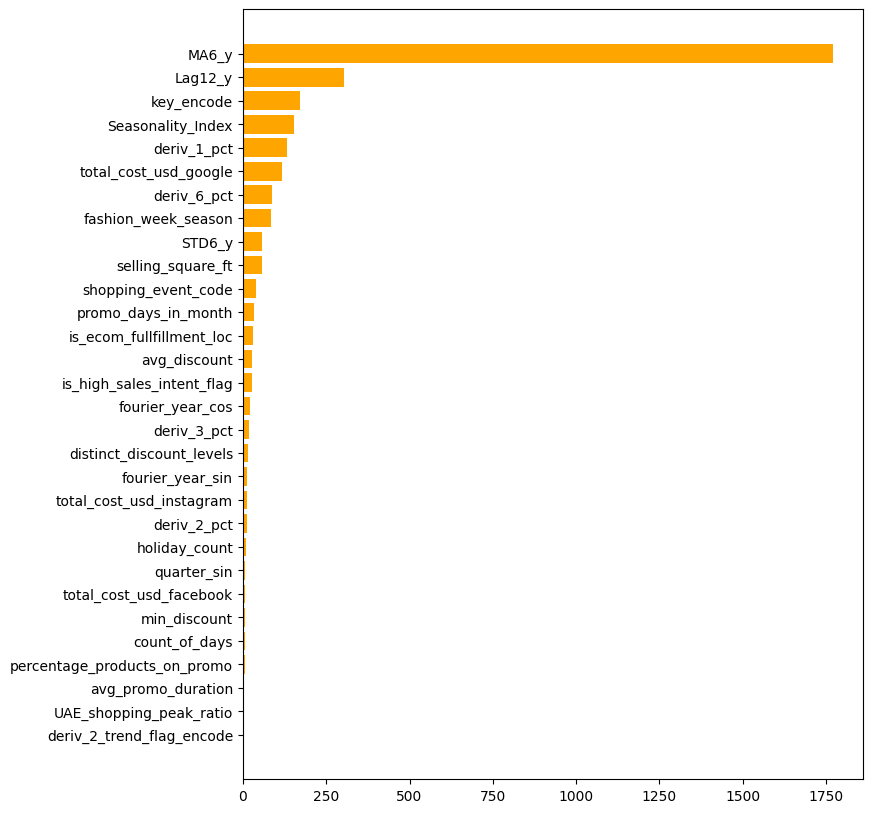

In [ ]:
import shap
import matplotlib.pyplot as plt
 
# Prepare SHAP explainer
explainer = shap.TreeExplainer(model)
 
# Select only numeric, boolean, or categorical columns
X_test_1_numeric = X_test_1.select_dtypes(include=["number", "bool", "category"])
 
# Compute SHAP values
shap_values = explainer.shap_values(X_test_1_numeric)
 
# Use class 1 for binary classification
if isinstance(shap_values, list):
    shap_values = shap_values[1]
 
# Create SHAP Explanation object
shap_values_obj = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    data=X_test_1_numeric,
    feature_names=X_test_1_numeric.columns
)
 
# Create a horizontal bar plot manually
# Calculate mean absolute SHAP value per feature
import pandas as pd
mean_abs_shap = pd.DataFrame({
    "feature": X_test_1_numeric.columns,
    "importance": np.abs(shap_values).mean(axis=0)
}).sort_values(by="importance", ascending=True)
 
# Limit to top 30 features
mean_abs_shap = mean_abs_shap.tail(30)
 
# Plot
plt.figure(figsize=(8, 10))
bars = plt.barh(mean_abs_shap["feature"], mean_abs_shap["importance"], color="orange")
plt.show()
# Add black text labels (importance values)
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}", va="center", ha="left", color="black", fontsize=9)
 
# Add title and labels
plt.title("Feature Importance (SHAP Values)", fontsize=14, fontweight='bold', pad=20)
plt.xlabel("Mean |SHAP Value|", fontsize=12)
plt.tight_layout()
 
# Save figure
plt.savefig("shap_summary_bar_horizontal.png", dpi=300, bbox_inches='tight')
plt.close()

#### lgbm

In [ ]:
import joblib

# Replace with your actual file path
file_path = "saved_models_v1/tuned/dec/lgbm_model.pkl"

with open(file_path, 'rb') as f:
    loaded = pickle.load(f)
print(type(loaded))


print(type(loaded[0]))
print(type(loaded[1]))

In [ ]:
import shap
model = loaded[0]  # if the first item is the LightGBM model

# Use TreeExplainer directly for LightGBM models
explainer = shap.TreeExplainer(model)

X_test_1_numeric = X_test_1.select_dtypes(include=["number", "bool", "category"])

# Now compute SHAP values
shap_values = explainer.shap_values(X_test_1_numeric)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_1_numeric, max_display=30, show=False)
plt.savefig("shap_summary_plot_lgbm.png", dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
import pandas as pd
import shap

# 1. Create SHAP explainer for LightGBM model
explainer = shap.TreeExplainer(model)

# 2. Compute SHAP values
shap_values = explainer.shap_values(X_test_1_numeric)

# 3. Convert SHAP values to importance DataFrame
# shap_values is an array (n_samples x n_features), so take mean absolute
shap_importance = pd.DataFrame({
    'feature': X_test_1_numeric.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=False)

# 4. Show importance table
print(shap_importance)

#### Random Forest

In [ ]:
import joblib

# Replace with your actual file path
file_path = "saved_models_v1/tuned/dec/random_forest_model.pkl"

with open(file_path, 'rb') as f:
    loaded = pickle.load(f)
print(type(loaded))


print(type(loaded[0]))
print(type(loaded[1]))

In [ ]:
import shap
model = loaded[0]  # if the first item is the LightGBM model

# Use TreeExplainer directly for LightGBM models
explainer = shap.TreeExplainer(model)

X_test_1_numeric = X_test_1.select_dtypes(include=["number", "bool", "category"])

# Now compute SHAP values
shap_values = explainer.shap_values(X_test_1_numeric)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_1_numeric, max_display=30, show=False)
plt.savefig("shap_summary_plot_lgbm.png", dpi=300, bbox_inches='tight')
plt.close()

In [ ]:
import pandas as pd
import shap

# 1. Create SHAP explainer for LightGBM model
explainer = shap.TreeExplainer(model)

# 2. Compute SHAP values
shap_values = explainer.shap_values(X_test_1_numeric)

# 3. Convert SHAP values to importance DataFrame
# shap_values is an array (n_samples x n_features), so take mean absolute
shap_importance = pd.DataFrame({
    'feature': X_test_1_numeric.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=False)

# 4. Show importance table
print(shap_importance)